Experimenting with new visualisations & features
---

---

In [ ]:
from pathlib import Path
import os
_cwd = os.getcwd()

In [ ]:
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()

In [ ]:
import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd

In [ ]:
# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 

In [ ]:
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from datasets import synth_dataset 

In [ ]:
import importlib
importlib.reload(experiments)
importlib.reload(metrics)
importlib.reload(datasets)
importlib.reload(models)
importlib.reload(EvaluationManager)
importlib.reload(score_disentanglement)

In [ ]:
handler = VectorModelHandler(model_name="VecESAE", model_version="standard", data="SynthVec", data_version="standard")

In [ ]:
checkpoints = handler.list_available_checkpoints()

In [ ]:
handler.load_checkpoint()

## Plotting Synthetic Vector dataset

Inspiration from https://github.com/derekbanas/seaborn/blob/master/SB%20Tut.ipynb

In [94]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [ ]:
train = handler.dataloader.train.dataset.dataset
print(train)

In [ ]:
graph_adj = train.get_graph_matrix()
graph_adj

In [ ]:
import networkx as nx

In [ ]:
figure = plt.figure(figsize=(7,4))
nx.draw(train.metadata["graph"], with_labels=True, 
        node_size=300, node_color="#99dddd", 
        edge_color="#55ff11", pos=nx.planar_layout(train.metadata["graph"])) 
#this could be a good plot to show 

In [ ]:
train.noise 

In [ ]:
np.std(train.original_labels, axis=0)

In [ ]:
samplers = train.metadata["samplers"] # maybe plot this - for each dimension its distribution
samplers

In [ ]:
equations = train.metadata["equations"]
discrete = train.metadata["discrete"]

In [ ]:
colors = ["blue", 'orange', 'green', 'red', 'purple', 'cyan', 'brown', 'pink', 'gray', 'olive']

In [ ]:
fig, axs = plt.subplots(nrows=len(samplers), figsize=(10,20))
for i in range(len(samplers)):
    if discrete[i]:
        sns.distplot(samplers[i].sample([10000]), ax = axs[i], kde=False)
    else:
        axs[i].set_xlim(-40,40)
        sns.distplot(samplers[i].sample([10000]), ax = axs[i])

In [ ]:
# one plot could be showing noise VS causal variables 

In [ ]:
X1,Y1,N1,X2,Y2,N2,metadata = train.read_source_files()

In [ ]:
#fig, axs = plt.subplots(nrows=len(samplers), figsize=(10,20))
for i in range(len(samplers)):
    sns.jointplot(N1[:,i], Y1[:,i], kind="kde")

In [ ]:
# one plot could be showing only the causal variables and their relationships 

In [ ]:
y_df = pd.DataFrame(y)

In [ ]:
sns.pairplot(y_df)

In [ ]:
sns.pairplot(y_df, kind="kde", corner=True)

In [ ]:
# one plot could be showing just the observables 

In [ ]:
train.data.shape

## Testing Evaluation Manager features

In [ ]:
#handler.model.cpu()
scores = handler.score_model(FID=False, disentanglement=True, orthogonality=True)

In [ ]:
scores

In [ ]:
scores['extra_disentanglement'] =None

In [ ]:
import json
base_path = Path(handler.config['logging_params']['save_dir']) / \
                        handler.config['logging_params']['name'] / \
                        handler.config['logging_params']['version'] / "scoring.json"
with open(base_path, 'w') as o:
    json.dump(scores, o)

In [ ]:
plots = handler.plot_model(do_originals=True, do_reconstructions=True, do_random_samples=True, do_traversals=True)

In [ ]:
plots["random_samples"]

## Collecting scores for synthetic vector dataset experiments

In [ ]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
data_versions = ["standard","discrete","continuous","big"]
model_names = ["VecESAE","VecSAE","VecVAE"]

In [ ]:
handlers=[]
for data_v in data_versions:
    for model_n in model_names: 
        handlers.append(VectorModelHandler(model_name=model_n, model_version="standard", 
                                           data="SynthVec", data_version=data_v))

In [ ]:
scores_df = pd.DataFrame()

In [ ]:
scores_df["model_name"] = model_names*len(data_versions)
scores_df["data_version"] = [item for data_v in data_versions for item in [data_v]*len(model_names)]

In [83]:
#scores = [handler.load_scores() for handler in handlers]

# - to go 
scores = [handlers[3].load_scores()]
scores[0]["extra_disentanglement"]=None

In [85]:
scores[0]

{'RBF': 0.0032230615615844727,
 'IMQ': 0.015416145324707031,
 'CAT': -0.020274218171834946,
 'DCI': 0.0694136536845892,
 'IRS': 0.5610840641689425,
 'MIG': 0.05763204301737647,
 'ModExp': 0.8246558640133556,
 'SAP': 0.0,
 'extra_disentanglement': None}

In [84]:
# - to go 
scores[0]["RBF"]= float(scores[0]["RBF"].detach().numpy())
scores[0]["IMQ"]= float(scores[0]["IMQ"].detach().numpy())
scores[0]["CAT"]= float(scores[0]["CAT"].detach().numpy())

In [86]:
for i,score_set in enumerate(scores): 
    for k,v in score_set.items():
        scores_df.loc[i,k] = v

In [122]:
# random fill - useful to test visualisations
for k,v in scores[0].items():
    scores_df.loc[:,k] = np.random.randn(12)**2
scores_df = scores_df.drop("extra_disentanglement", axis=1)

In [123]:
scores_df

,model_name,data_version,RBF,IMQ,CAT,DCI,IRS,MIG,ModExp,SAP
0,VecESAE,standard,0.922531,0.195981,0.135733,0.025875,1.296394,3.101724,0.000055,0.027982
1,VecSAE,standard,0.217321,2.717965,0.069774,0.658972,0.333510,0.274792,0.389401,0.883966
2,VecVAE,standard,0.000650,0.919673,0.211470,0.525983,0.525249,0.432384,0.668693,0.013438
3,VecESAE,discrete,0.481484,0.196779,0.008725,0.345609,1.229369,0.244584,5.555475,3.091507
4,VecSAE,discrete,4.384879,0.000758,1.023417,2.333982,1.173743,0.551408,0.061321,0.000629
5,VecVAE,discrete,0.000905,0.062565,0.130773,1.111394,1.635872,0.188964,0.949581,0.314047
6,VecESAE,continuous,0.691006,0.024623,3.011057,1.168068,0.993226,0.724821,0.116920,4.685353
7,VecSAE,continuous,1.408425,0.012124,0.570596,2.351172,2.029472,0.014952,0.104565,2.951960
8,VecVAE,continuous,1.588681,0.777924,0.350144,0.486185,0.049829,3.483123,0.121290,1.194271
9,VecESAE,big,0.004847,0.744685,0.053684,0.037942,0.163021,1.572520,0.995625,0.147867


## Visualisations of model scores

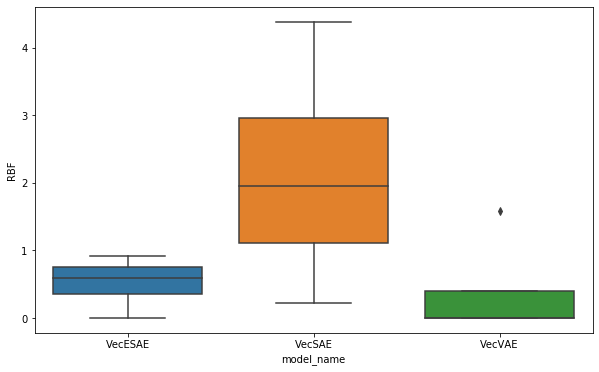

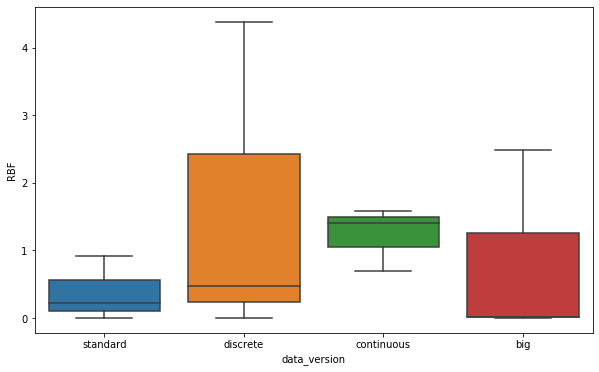

In [124]:
# finally visualising 
plt.figure(figsize=(10,6))
sns.boxplot(x='model_name',y='RBF',data=scores_df)
# finally visualising 
plt.figure(figsize=(10,6))
sns.boxplot(x='data_version',y='RBF',data=scores_df)


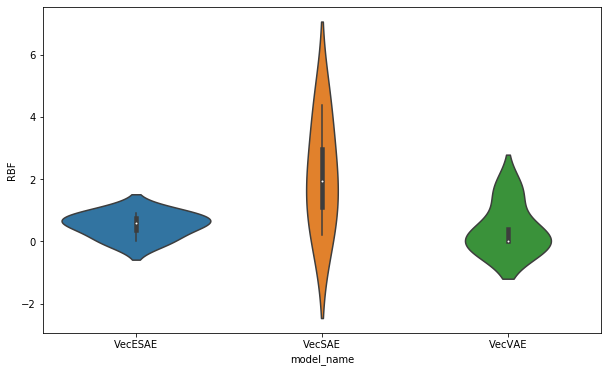

In [125]:
plt.figure(figsize=(10,6))
sns.violinplot(x='model_name',y='RBF',data=scores_df, split=True)
#sns.swarmplot(x='model_name',y='RBF',data=scores_df, split=True, color="white")

In [139]:
scores_df.columns[2:5]

Index(['RBF', 'IMQ', 'CAT'], dtype='object')

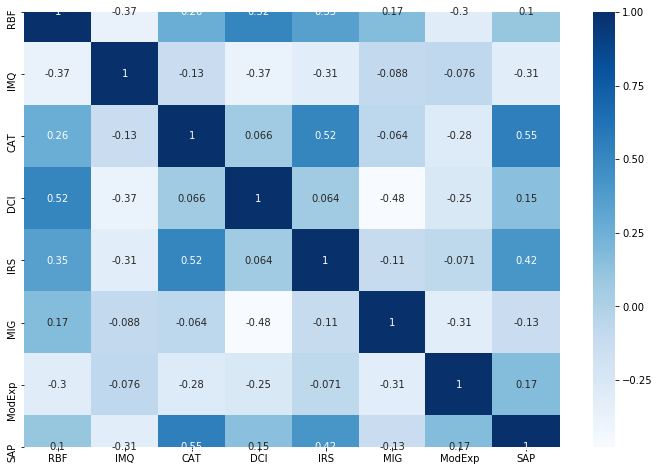

In [129]:
plt.figure(figsize=(12,8))

scores_corr = scores_df.corr()
sns.heatmap(scores_corr, annot=True, cmap='Blues')


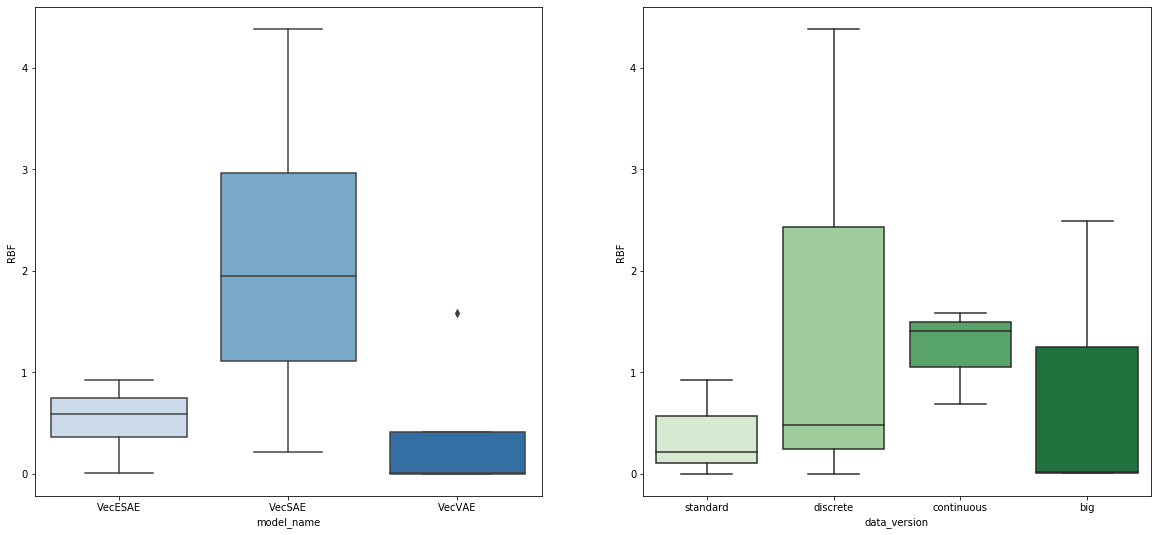

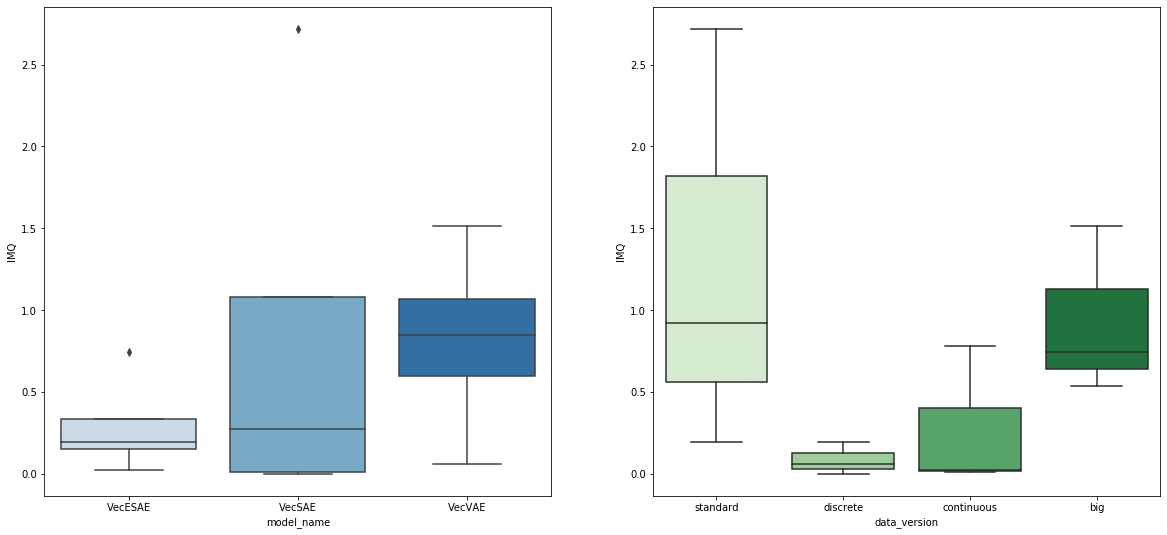

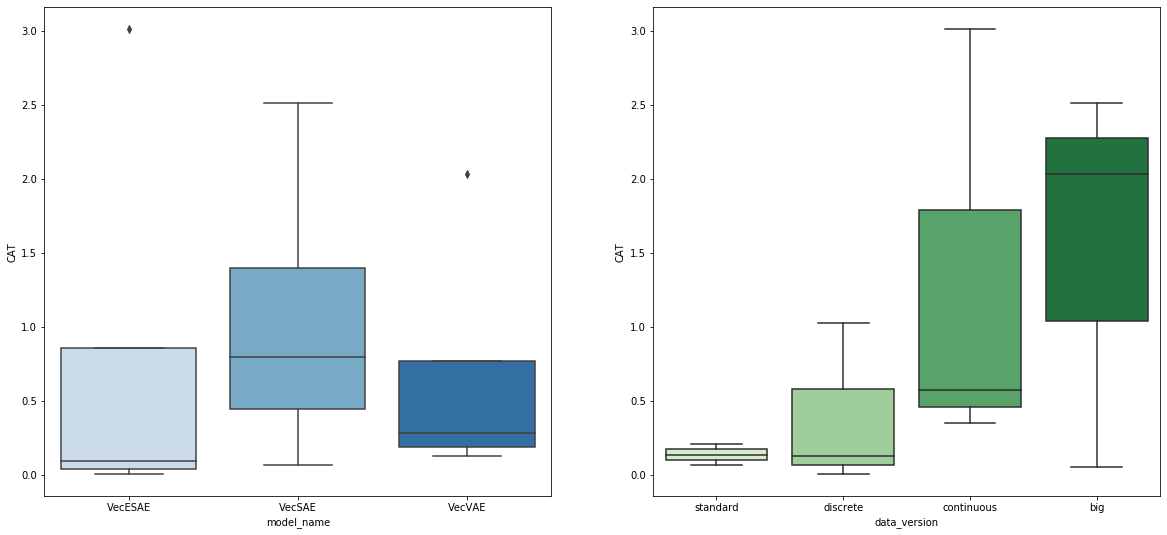

In [153]:
for k in scores_df.columns[2:5]: # orthogonality
    fig, axs = plt.subplots(ncols=2, figsize=(20,9))
    sns.boxplot(x='model_name',y=k,data=scores_df, ax=axs[0], palette="Blues")
    sns.boxplot(x='data_version',y=k,data=scores_df, ax=axs[1], palette="Greens")

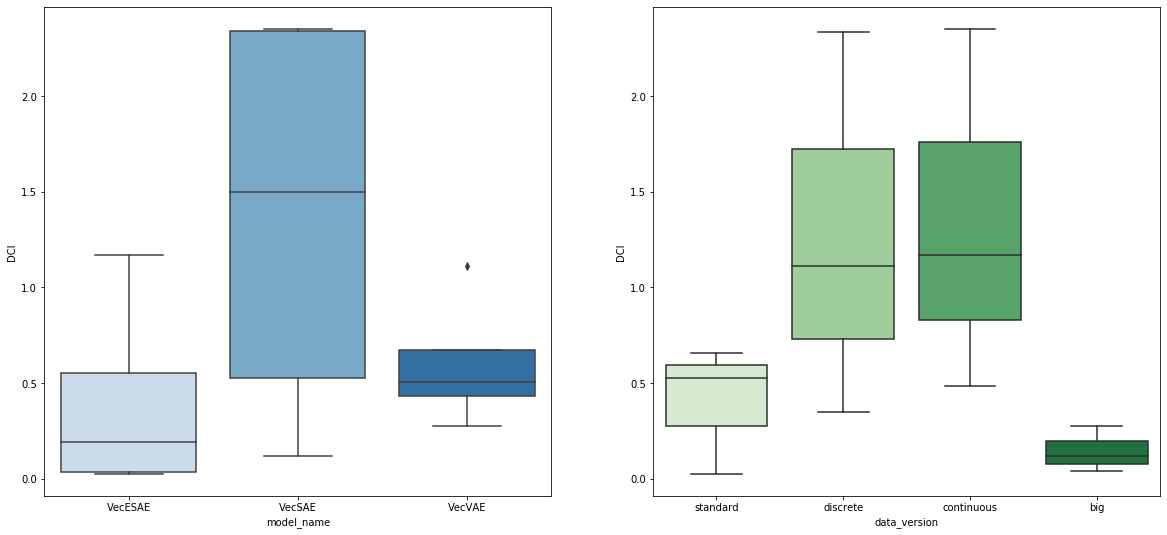

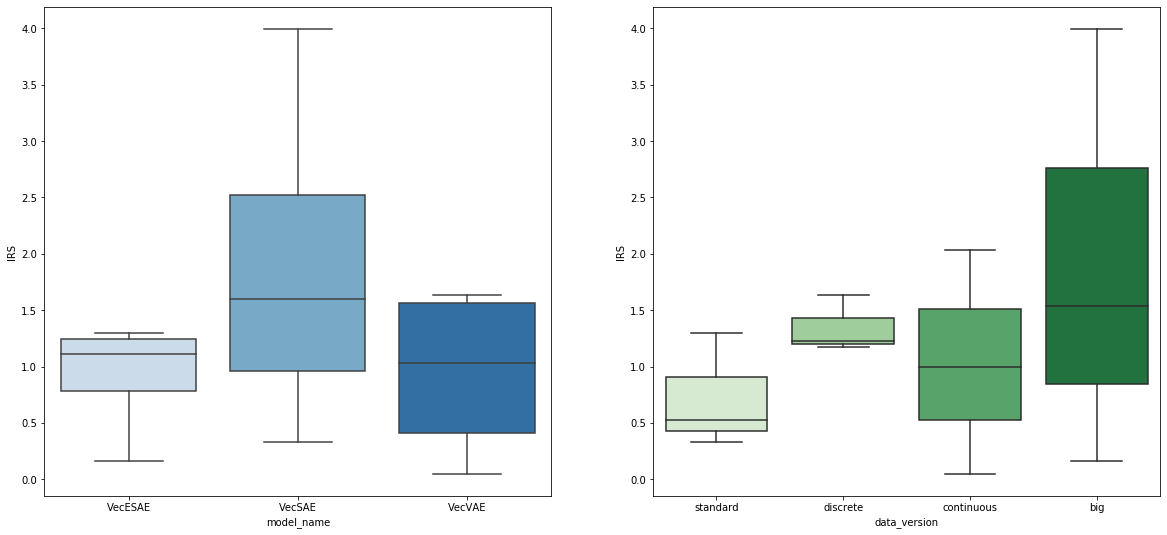

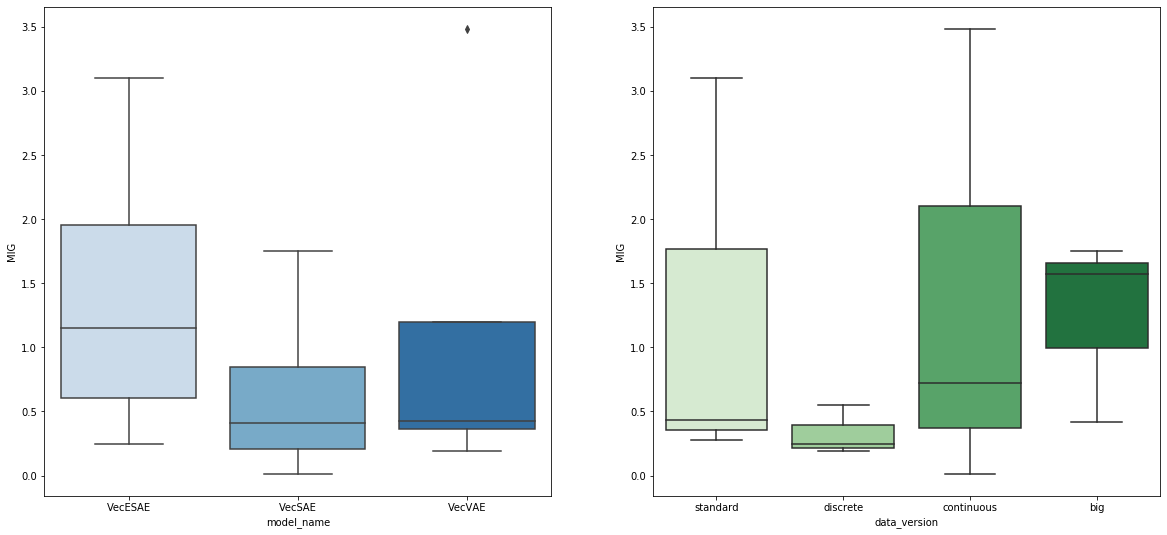

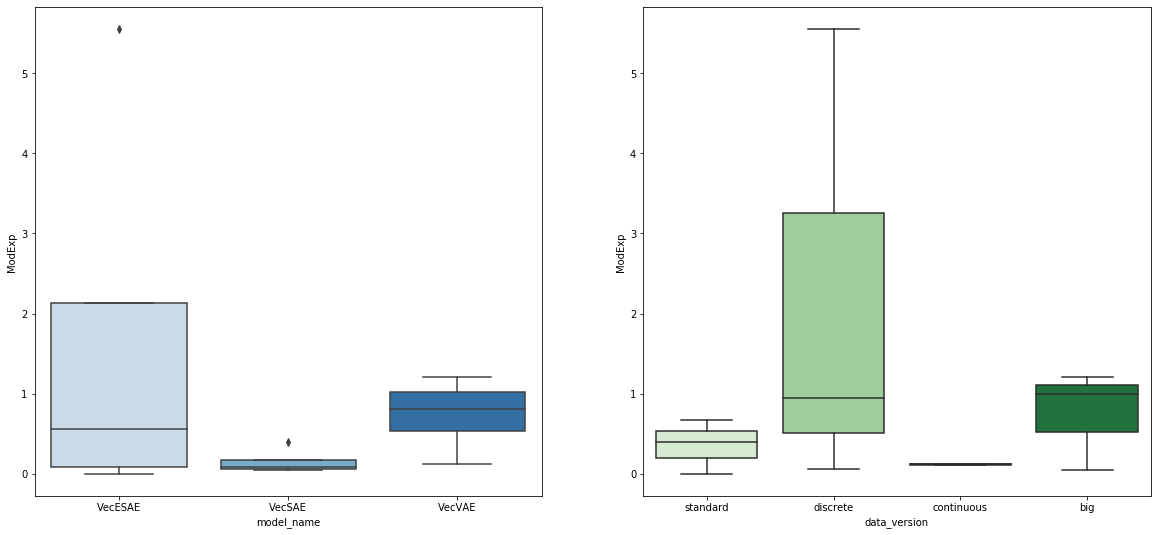

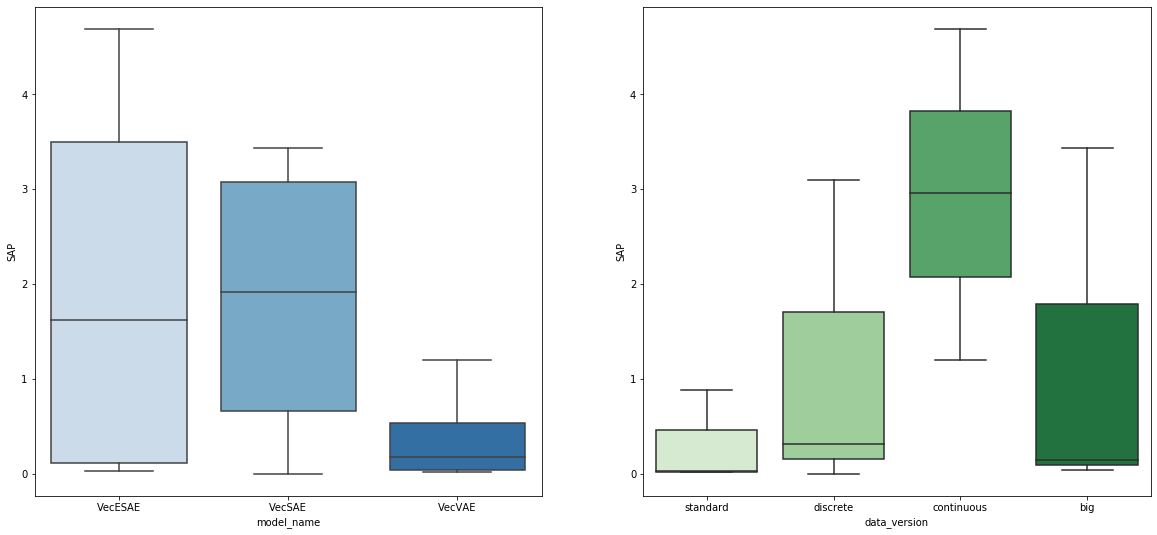

In [160]:
# finally visualising 
for k in scores_df.columns[5:]: # disentanglement
    fig, axs = plt.subplots(ncols=2, figsize=(20,9))
    sns.boxplot(x='model_name',y=k,data=scores_df, ax=axs[0], palette="Blues")
    sns.boxplot(x='data_version',y=k,data=scores_df, ax=axs[1], palette="Greens")